In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (log_loss, brier_score_loss, roc_auc_score, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ks_2samp, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

class CalibrationEvaluator:
    """Comprehensive calibration evaluation and statistical testing framework"""
    
    def __init__(self, n_bins=10, cv_folds=5):
        self.n_bins = n_bins
        self.cv_folds = cv_folds
        self.results = {}
        
    def hosmer_lemeshow_test(self, y_true, y_prob, n_bins=10):
        """
        Perform Hosmer-Lemeshow goodness-of-fit test for calibration
        """
        # Create bins based on predicted probabilities
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        observed = []
        expected = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Find samples in this bin
            in_bin = (y_prob >= bin_lower) & (y_prob < bin_upper)
            if bin_upper == 1.0:  # Include the upper bound for the last bin
                in_bin = (y_prob >= bin_lower) & (y_prob <= bin_upper)
                
            if np.sum(in_bin) > 0:
                observed_events = np.sum(y_true[in_bin])
                expected_events = np.sum(y_prob[in_bin])
                observed.append([observed_events, np.sum(in_bin) - observed_events])
                expected.append([expected_events, np.sum(in_bin) - expected_events])
        
        if len(observed) < 2:
            return np.nan, np.nan
            
        observed = np.array(observed)
        expected = np.array(expected)
        
        # Calculate chi-square statistic
        chi2_stat = np.sum((observed - expected) ** 2 / (expected + 1e-10))
        df = len(observed) - 2
        p_value = 1 - stats.chi2.cdf(chi2_stat, df) if df > 0 else np.nan
        
        return chi2_stat, p_value
    
    def expected_calibration_error(self, y_true, y_prob, n_bins=10):
        """
        Calculate Expected Calibration Error (ECE)
        """
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        total_samples = len(y_true)
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
            prop_in_bin = in_bin.mean()
            
            if prop_in_bin > 0:
                accuracy_in_bin = y_true[in_bin].mean()
                avg_confidence_in_bin = y_prob[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                
        return ece
    
    def maximum_calibration_error(self, y_true, y_prob, n_bins=10):
        """
        Calculate Maximum Calibration Error (MCE)
        """
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        mce = 0
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
            
            if in_bin.sum() > 0:
                accuracy_in_bin = y_true[in_bin].mean()
                avg_confidence_in_bin = y_prob[in_bin].mean()
                mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
                
        return mce
    
    def reliability_diagram_data(self, y_true, y_prob, n_bins=10):
        """
        Generate data for reliability diagram
        """
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        bin_centers = []
        bin_accuracies = []
        bin_counts = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
            
            if in_bin.sum() > 0:
                bin_centers.append((bin_lower + bin_upper) / 2)
                bin_accuracies.append(y_true[in_bin].mean())
                bin_counts.append(in_bin.sum())
        
        return np.array(bin_centers), np.array(bin_accuracies), np.array(bin_counts)
    
    def bootstrap_confidence_intervals(self, y_true, y_prob, metric_func, n_bootstrap=1000, alpha=0.05):
        """
        Calculate bootstrap confidence intervals for calibration metrics
        """
        n_samples = len(y_true)
        bootstrap_scores = []
        
        for _ in range(n_bootstrap):
            # Bootstrap sample
            indices = np.random.choice(n_samples, n_samples, replace=True)
            bootstrap_scores.append(metric_func(y_true[indices], y_prob[indices]))
        
        bootstrap_scores = np.array(bootstrap_scores)
        lower = np.percentile(bootstrap_scores, 100 * alpha / 2)
        upper = np.percentile(bootstrap_scores, 100 * (1 - alpha / 2))
        
        return lower, upper
    
    def compare_calibrations(self, y_true, prob1, prob2, method1_name="Method 1", method2_name="Method 2"):
        """
        Statistical comparison between two calibration methods
        """
        # Kolmogorov-Smirnov test
        ks_stat, ks_p = ks_2samp(prob1, prob2)
        
        # Mann-Whitney U test for probability distributions
        mw_stat, mw_p = mannwhitneyu(prob1, prob2, alternative='two-sided')
        
        # Compare log losses
        ll1 = log_loss(y_true, prob1)
        ll2 = log_loss(y_true, prob2)
        
        # Compare Brier scores
        bs1 = brier_score_loss(y_true, prob1)
        bs2 = brier_score_loss(y_true, prob2)
        
        comparison_results = {
            'ks_statistic': ks_stat,
            'ks_p_value': ks_p,
            'mw_statistic': mw_stat,
            'mw_p_value': mw_p,
            'log_loss_diff': ll2 - ll1,
            'brier_score_diff': bs2 - bs1,
            f'{method1_name}_log_loss': ll1,
            f'{method2_name}_log_loss': ll2,
            f'{method1_name}_brier_score': bs1,
            f'{method2_name}_brier_score': bs2
        }
        
        return comparison_results
    
    def comprehensive_evaluation(self, y_true, probabilities, method_names):
        """
        Perform comprehensive evaluation of multiple calibration methods
        """
        results = {}
        
        for method_name, probs in zip(method_names, probabilities):
            # Basic metrics
            results[method_name] = {
                'log_loss': log_loss(y_true, probs),
                'brier_score': brier_score_loss(y_true, probs),
                'roc_auc': roc_auc_score(y_true, probs),
                'ece': self.expected_calibration_error(y_true, probs, self.n_bins),
                'mce': self.maximum_calibration_error(y_true, probs, self.n_bins),
            }
            
            # Hosmer-Lemeshow test
            hl_stat, hl_p = self.hosmer_lemeshow_test(y_true, probs, self.n_bins)
            results[method_name]['hosmer_lemeshow_stat'] = hl_stat
            results[method_name]['hosmer_lemeshow_p'] = hl_p
            
            # Bootstrap confidence intervals
            ece_ci = self.bootstrap_confidence_intervals(y_true, probs, 
                                                       lambda y, p: self.expected_calibration_error(y, p, self.n_bins))
            results[method_name]['ece_ci'] = ece_ci
            
            brier_ci = self.bootstrap_confidence_intervals(y_true, probs, brier_score_loss)
            results[method_name]['brier_ci'] = brier_ci
        
        self.results = results
        return results


In [3]:
# Generate synthetic dataset
def generate_synthetic_data(n_samples=1000, n_features=10):
    """Generate synthetic binary classification dataset."""
    X = np.random.rand(n_samples, n_features)
    # Create binary labels based on simple threshold rule
    y = (X[:, 0] + X[:, 1] > 1).astype(int)
    return X, y

# Generate data and split into train/test sets
X, y = generate_synthetic_data(n_samples=1000, n_features=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Positive class ratio: {np.mean(y_train):.3f}")


Training samples: 800
Test samples: 200
Positive class ratio: 0.477


In [4]:
# Train base Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5
)
rf_classifier.fit(X_train, y_train)

# Get uncalibrated probabilities
rf_probs_uncalibrated = rf_classifier.predict_proba(X_test)[:, 1]

# Apply calibration using Platt scaling (sigmoid)
calibrated_clf_platt = CalibratedClassifierCV(
    rf_classifier, 
    method='sigmoid', 
    cv=3
)
calibrated_clf_platt.fit(X_train, y_train)
rf_probs_platt = calibrated_clf_platt.predict_proba(X_test)[:, 1]

# Apply calibration using isotonic regression
calibrated_clf_isotonic = CalibratedClassifierCV(
    rf_classifier, 
    method='isotonic', 
    cv=3
)
calibrated_clf_isotonic.fit(X_train, y_train)
rf_probs_isotonic = calibrated_clf_isotonic.predict_proba(X_test)[:, 1]

# Initialize evaluator
evaluator = CalibrationEvaluator(n_bins=10, cv_folds=5)

# Comprehensive evaluation
probabilities = [rf_probs_uncalibrated, rf_probs_platt, rf_probs_isotonic]
method_names = ['Uncalibrated', 'Platt_Scaling', 'Isotonic_Regression']

results = evaluator.comprehensive_evaluation(y_test, probabilities, method_names)

# Print comprehensive results
print("\n" + "="*80)
print("COMPREHENSIVE CALIBRATION EVALUATION RESULTS")
print("="*80)

results_df = pd.DataFrame(results).T
print("\nSummary Statistics:")
print(results_df.round(4))

# Statistical comparisons
print("\n" + "-"*60)
print("STATISTICAL COMPARISONS")
print("-"*60)


COMPREHENSIVE CALIBRATION EVALUATION RESULTS

Summary Statistics:
                     log_loss brier_score   roc_auc       ece       mce  \
Uncalibrated          0.28243    0.071765  0.994091  0.190505  0.339202   
Platt_Scaling        0.128513    0.035813  0.994591  0.057232   0.25295   
Isotonic_Regression  0.113061    0.033838  0.994641  0.052407  0.452837   

                    hosmer_lemeshow_stat hosmer_lemeshow_p  \
Uncalibrated                   46.394724               0.0   
Platt_Scaling                  11.934278           0.15416   
Isotonic_Regression            12.338442           0.13673   

                                                         ece_ci  \
Uncalibrated          (0.16770282957614605, 0.2145251851094401)   
Platt_Scaling        (0.04833864648453893, 0.08586754065319684)   
Isotonic_Regression  (0.038216727838500435, 0.0793149063678046)   

                                                         brier_ci  
Uncalibrated           (0.06168344337432307, 0

In [5]:
# Compare Platt scaling vs Uncalibrated
platt_vs_uncal = evaluator.compare_calibrations(
    y_test, rf_probs_uncalibrated, rf_probs_platt, 
    "Uncalibrated", "Platt_Scaling"
)

print("\nPlatt Scaling vs Uncalibrated:")
for key, value in platt_vs_uncal.items():
    if 'p_value' in key:
        significance = "***" if value < 0.001 else "**" if value < 0.01 else "*" if value < 0.05 else ""
        print(f"  {key}: {value:.6f} {significance}")
    else:
        print(f"  {key}: {value:.6f}")


Platt Scaling vs Uncalibrated:
  ks_statistic: 0.370000
  ks_p_value: 0.000000 ***
  mw_statistic: 20594.000000
  mw_p_value: 0.607710 
  log_loss_diff: -0.153918
  brier_score_diff: -0.035952
  Uncalibrated_log_loss: 0.282430
  Platt_Scaling_log_loss: 0.128513
  Uncalibrated_brier_score: 0.071765
  Platt_Scaling_brier_score: 0.035813


In [6]:
# Compare Isotonic vs Uncalibrated
isotonic_vs_uncal = evaluator.compare_calibrations(
    y_test, rf_probs_uncalibrated, rf_probs_isotonic, 
    "Uncalibrated", "Isotonic_Regression"
)

print("\nIsotonic Regression vs Uncalibrated:")
for key, value in isotonic_vs_uncal.items():
    if 'p_value' in key:
        significance = "***" if value < 0.001 else "**" if value < 0.01 else "*" if value < 0.05 else ""
        print(f"  {key}: {value:.6f} {significance}")
    else:
        print(f"  {key}: {value:.6f}")


Isotonic Regression vs Uncalibrated:
  ks_statistic: 0.380000
  ks_p_value: 0.000000 ***
  mw_statistic: 20631.000000
  mw_p_value: 0.584182 
  log_loss_diff: -0.169369
  brier_score_diff: -0.037927
  Uncalibrated_log_loss: 0.282430
  Isotonic_Regression_log_loss: 0.113061
  Uncalibrated_brier_score: 0.071765
  Isotonic_Regression_brier_score: 0.033838


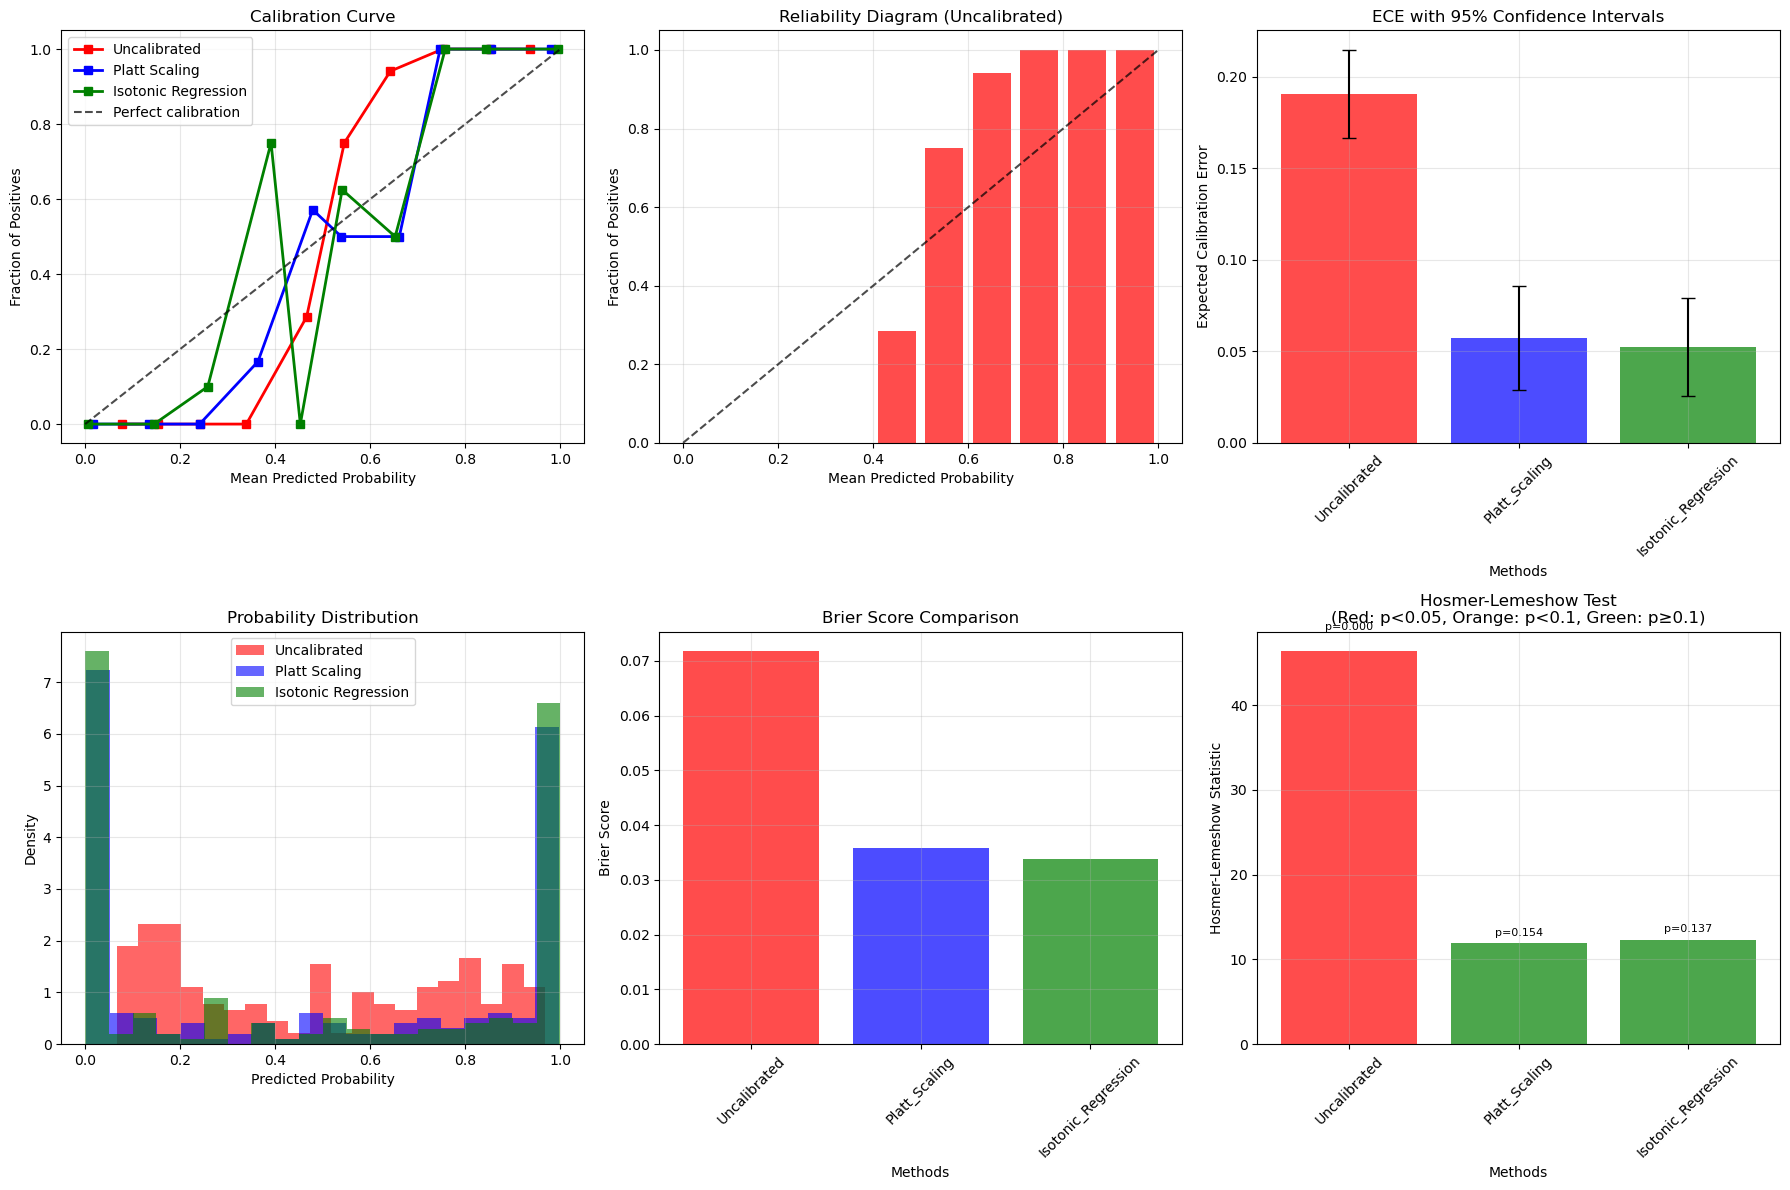

In [7]:
# Enhanced visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Calibration curve with confidence bands
fraction_pos_uncal, mean_pred_uncal = calibration_curve(y_test, rf_probs_uncalibrated, n_bins=10)
fraction_pos_platt, mean_pred_platt = calibration_curve(y_test, rf_probs_platt, n_bins=10)
fraction_pos_isotonic, mean_pred_isotonic = calibration_curve(y_test, rf_probs_isotonic, n_bins=10)

axes[0,0].plot(mean_pred_uncal, fraction_pos_uncal, "s-", label="Uncalibrated", color='red', linewidth=2)
axes[0,0].plot(mean_pred_platt, fraction_pos_platt, "s-", label="Platt Scaling", color='blue', linewidth=2)
axes[0,0].plot(mean_pred_isotonic, fraction_pos_isotonic, "s-", label="Isotonic Regression", color='green', linewidth=2)
axes[0,0].plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.7)
axes[0,0].set_xlabel("Mean Predicted Probability")
axes[0,0].set_ylabel("Fraction of Positives")
axes[0,0].set_title("Calibration Curve")
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Reliability diagram with sample counts
bin_centers, bin_accs, bin_counts = evaluator.reliability_diagram_data(y_test, rf_probs_uncalibrated)
axes[0,1].bar(bin_centers, bin_accs, width=0.08, alpha=0.7, label='Uncalibrated', color='red')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.7)
axes[0,1].set_xlabel('Mean Predicted Probability')
axes[0,1].set_ylabel('Fraction of Positives')
axes[0,1].set_title('Reliability Diagram (Uncalibrated)')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: ECE comparison
methods = list(results.keys())
ece_values = [results[method]['ece'] for method in methods]
ece_cis = [results[method]['ece_ci'] for method in methods]

x_pos = np.arange(len(methods))
axes[0,2].bar(x_pos, ece_values, yerr=[ci[1] - ece_values[i] for i, ci in enumerate(ece_cis)], 
              capsize=5, alpha=0.7, color=['red', 'blue', 'green'])
axes[0,2].set_xlabel('Methods')
axes[0,2].set_ylabel('Expected Calibration Error')
axes[0,2].set_title('ECE with 95% Confidence Intervals')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(methods, rotation=45)
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Probability distributions
axes[1,0].hist(rf_probs_uncalibrated, bins=20, alpha=0.6, label="Uncalibrated", color='red', density=True)
axes[1,0].hist(rf_probs_platt, bins=20, alpha=0.6, label="Platt Scaling", color='blue', density=True)
axes[1,0].hist(rf_probs_isotonic, bins=20, alpha=0.6, label="Isotonic Regression", color='green', density=True)
axes[1,0].set_xlabel("Predicted Probability")
axes[1,0].set_ylabel("Density")
axes[1,0].set_title("Probability Distribution")
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Brier score decomposition
brier_scores = [results[method]['brier_score'] for method in methods]
axes[1,1].bar(x_pos, brier_scores, alpha=0.7, color=['red', 'blue', 'green'])
axes[1,1].set_xlabel('Methods')
axes[1,1].set_ylabel('Brier Score')
axes[1,1].set_title('Brier Score Comparison')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(methods, rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Hosmer-Lemeshow test results
hl_stats = [results[method]['hosmer_lemeshow_stat'] for method in methods]
hl_ps = [results[method]['hosmer_lemeshow_p'] for method in methods]

# Create color map based on p-values
colors = ['red' if p < 0.05 else 'orange' if p < 0.1 else 'green' for p in hl_ps]
bars = axes[1,2].bar(x_pos, hl_stats, alpha=0.7, color=colors)
axes[1,2].set_xlabel('Methods')
axes[1,2].set_ylabel('Hosmer-Lemeshow Statistic')
axes[1,2].set_title('Hosmer-Lemeshow Test\n(Red: p<0.05, Orange: p<0.1, Green: p≥0.1)')
axes[1,2].set_xticks(x_pos)
axes[1,2].set_xticklabels(methods, rotation=45)
axes[1,2].grid(True, alpha=0.3)

# Add p-values as text on bars
for i, (bar, p) in enumerate(zip(bars, hl_ps)):
    height = bar.get_height()
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height + height*0.05,
                   f'p={p:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [8]:
# Generate summary report
print("\n" + "="*80)
print("CALIBRATION ANALYSIS SUMMARY REPORT")
print("="*80)

best_ece = min(results.keys(), key=lambda x: results[x]['ece'])
best_brier = min(results.keys(), key=lambda x: results[x]['brier_score'])
best_log_loss = min(results.keys(), key=lambda x: results[x]['log_loss'])

print(f"\nBest performing methods:")
print(f"  Lowest ECE: {best_ece} (ECE = {results[best_ece]['ece']:.4f})")
print(f"  Lowest Brier Score: {best_brier} (Brier = {results[best_brier]['brier_score']:.4f})")
print(f"  Lowest Log Loss: {best_log_loss} (Log Loss = {results[best_log_loss]['log_loss']:.4f})")

print(f"\nCalibration quality assessment:")
for method in methods:
    hl_p = results[method]['hosmer_lemeshow_p']
    calibration_quality = "Well calibrated" if hl_p > 0.05 else "Poorly calibrated"
    print(f"  {method}: {calibration_quality} (Hosmer-Lemeshow p = {hl_p:.4f})")



CALIBRATION ANALYSIS SUMMARY REPORT

Best performing methods:
  Lowest ECE: Isotonic_Regression (ECE = 0.0524)
  Lowest Brier Score: Isotonic_Regression (Brier = 0.0338)
  Lowest Log Loss: Isotonic_Regression (Log Loss = 0.1131)

Calibration quality assessment:
  Uncalibrated: Poorly calibrated (Hosmer-Lemeshow p = 0.0000)
  Platt_Scaling: Well calibrated (Hosmer-Lemeshow p = 0.1542)
  Isotonic_Regression: Well calibrated (Hosmer-Lemeshow p = 0.1367)
